### **Difference-in-Difference**

#### **The experimental ideal**

- We can randomly assign experimental units to treatment - control -> manage selection bias
- conditional independence assumption holds
- issues for inference: heteroskedasticity and clustering

#### **The 'quasi-experimental' setting**
- Based on the parallel trend assumption:

    *In the absence of treatment, the difference between the treated and control groups would have remained the same over time*

- Simply taking differences between control and treatment, or between pre- and post-treatment, doesn't work:
    - Control vs. treatment: We may have **ommited variable bias**, even after controlling by other factors via OLS (i.e., observing additional variables to correct for them in the model)
    - Pre- vs. post-treatment: As above, evolution can be due to other factors.
    
- **Fundamental problem of causal inference**: we cannot observe the evolution the treatment group would have had without treatment, so we don't have an direct counterfactual. DiD tries to approximate this.

#### **Main idea of DiD**
- Treatment and control groups have similar evolution pre-treatment and this extends to the post-treatment period.
- In other words, observed and unobserved differences between control and treatment remain constant
- This way, all the change in the treatment group post-treatment is attributable to the treatment
- Then, we can:
    - Take difference after - before treatment in each group (control and treatment) -> removes the temporal trend in each group (**as long as it's the same in control and treatment, see assumption above**)
    - Take the difference between control and treatment group at each time (before and after treatment) -> removes the constant (**assumed!**) difference between them
    - Take the difference between these two differences: **if assumtion holds**, the remaining difference is the **treatment effect**

Graph below illustrates this point:

In [121]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf

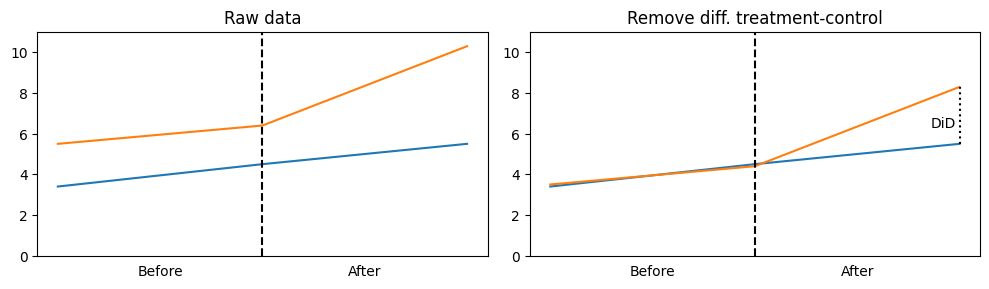

In [21]:
df = pd.DataFrame({'index': [0, 0.5, 1], 'control': [3.4, 4.5, 5.5], 'treatment': [5.5, 6.4, 10.3]}).set_index('index')

def make_subplot(ax, title, time, treatment, control):
    ax.set_title(title)
    ax.plot(time, control, label='control')
    ax.plot(time, treatment, label='treatment')
    ax.axvline(0.5, c='black', linestyle='--')
    ax.set_xticks([])
    ax.set_xticklabels([])
    ax.set_ylim(0, 11)
    ax.text(0.25, -1, 'Before', fontsize=10, ha='center')
    ax.text(0.75, -1, 'After', fontsize=10, ha='center')

fig, ax = plt.subplots(1, 2, figsize=(10, 3))
make_subplot(ax[0], 'Raw data', df.index, df['treatment'], df['control'])
make_subplot(ax[1], 'Remove diff. treatment-control', df.index, df['treatment'] - 2, df['control'])
ax[1].vlines(x=df.index[-1], ymin=5.5, ymax=8.3, linestyle=':', color='black')
ax[1].text(0.93, 6.3, 'DiD', fontsize=10, ha='left')
plt.tight_layout()
plt.show()

### How to check parallel trends assumption?
- Visual inspection
- Placebo effect: run DiD for time periods before treatment and see if you find an effect
- Synthetic control: build a weighted combination of control units that closely resembles the pre-treatment trend of the treatment group 

### **The math**

The DiD model consists of the following elements:
- $Y_{it}$ = outcome for group $i$ (treatment or control) at time $t$
- $T_i$ = treatment indicator, 1 if treatment, 0 if not
- $P_t$ = time indicator, 0 before treatment, 1 after
- Model: $Y_{it} = \beta_0 + \beta_1T_i + \beta_2P_t + \beta_3(T_i \times P_t) + \epsilon_{it}$
- Elements:
    - $\beta_0$ = baseline outcome, i.e., $Y_{it}$ before treatment in control group
    - $\beta_1 $ = effect of difference between groups before treatment 
    - $\beta_2 $ = effect of time trends in both groups
    - $\beta_3$ = **DiD estimator**
    - $\epsilon_{it}$ = random error with mean $\mu=0$ and variance $\sigma$

#### Expected values before/after/control/treatment

- Before treatment, control group: 
    - $E[Y_{it}|P_t = 0, T_i = 0] = E[\beta_0 + \beta_1T_i + \beta_2P_t + \beta_3(T_i \times P_t) + \epsilon_{it}]$ 
    - $E[Y_{it}|P_t = 0, T_i = 0] = \beta_0$
- Before treatment, treatment group: 
    - $E[Y_{it}|P_t = 0, T_i = 1] = \beta_0 + \beta_1$
- After treatment, control group: 
    - $E[Y_{it}|P_t = 1, T_i = 0] = \beta_0 + \beta_2$
- After treatment, treatment group: 
    - $E[Y_{it}|P_t = 1, T_i = 1] = \beta_0 + \beta_1 + \beta_2 + \beta_3$


### **An example with synthetic data**

In [119]:
np.random.seed(42)

n_time = 10  # n periods
n_units = 100  # n units per group

time_periods = np.tile(np.arange(n_time), n_units * 2) # t=0 ... t=9 for each unit in each group, i.e., n = 10 (times) x 2 (groups) x n_units
group = np.repeat(['control', 'treatment'], n_units * n_time)  # repeat 'control' n_time x n_units times, then same for 'treatment'  
unit_id = np.tile(np.repeat(np.arange(n_units), n_time), 2) # repeat same unit_id n_time times, same for all unit ids, then the whole thing 2 times (control, treatment)

# control, base outcome grows with time (slope = 2), add normal random noise with sigma=1.3
base_outcome = 50 + time_periods * 2 + np.random.normal(0, 1.3, size=len(time_periods))

# treatment: after t=5, base outcome x 5
treatment_effect = (time_periods >= 5) * (group == 'treatment') * 5

# yobs
outcome = base_outcome + treatment_effect

# Create a DataFrame
df = pd.DataFrame({
    'unit_id': unit_id,
    'time': time_periods,
    'group': group,
    'outcome': outcome
})

df

,unit_id,time,group,outcome
0,0,0,control,50.645728
1,0,1,control,51.820256
2,0,2,control,54.841995
3,0,3,control,57.979939
4,0,4,control,57.695601
...,...,...,...,...
1995,99,5,treatment,66.391195
1996,99,6,treatment,66.965522
1997,99,7,treatment,67.853563
1998,99,8,treatment,70.788013


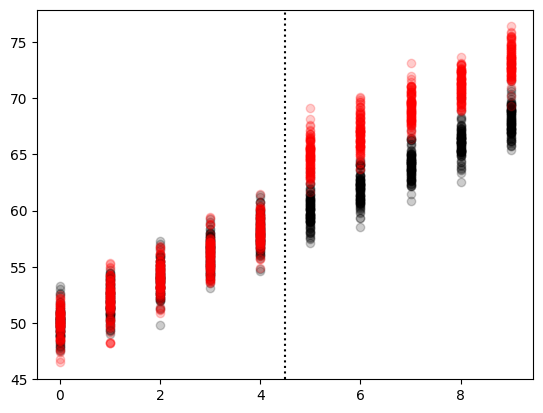

In [114]:
fig, ax = plt.subplots()
ax.scatter(df[df['group'] == 'control']['time'], df[df['group'] == 'control']['outcome'], color='black', alpha=0.2, label='control')
ax.scatter(df[df['group'] == 'treatment']['time'], df[df['group']=='treatment']['outcome'], color='red', alpha=0.2, label='tratment')
ax.axvline(x=4.5, linestyle=':', color='black')
plt.show()

In [120]:
# create DiD variables
df['post'] = (df['time'] >= 5).astype(int)  # 1 if post-treatment, 0 otherwise
df['treatment'] = (df['group'] == 'treatment').astype(int)  # 1 if treatment, 0 otherwise
df['interaction'] = df['treatment'] * df['post']  # Interaction term

# DiD regression
model = smf.ols("outcome ~ treatment + post + interaction", data=df).fit()

# Print results
print(model.summary())


                            OLS Regression Results                            
Dep. Variable:                outcome   R-squared:                       0.808
Model:                            OLS   Adj. R-squared:                  0.808
Method:                 Least Squares   F-statistic:                     2808.
Date:                Mon, 10 Feb 2025   Prob (F-statistic):               0.00
Time:                        21:48:26   Log-Likelihood:                -5140.6
No. Observations:                2000   AIC:                         1.029e+04
Df Residuals:                    1996   BIC:                         1.031e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept      54.0380      0.142    381.703      